# Synth PCA-SVM Classification

This work uses synthetic spectra data to classify samples into various labeled classes. <br> This is a work in progress.

Author: Zheng Tang <br>
Baseline correction algorithm: Edward Duckworth <br>
Collab: Dr. Deb Roy, Dr. Ben Mora

In [1]:
# Usuals
import pandas as pd
import numpy as np
import random
from numpy import arange
import matplotlib.pyplot as plt
import pickle
import platform
import sys
import sklearn as sk
import math


# Statistics
from scipy import stats

# Utility functions
%load_ext autoreload
from Utilities import baseline_als, generate_alss, scale, get_scenario_specs, combine_all_urine_csv, generate_augmentation
%aimport Utilities

# PCA
from sklearn import decomposition

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Scaling
from sklearn.preprocessing import StandardScaler

# LOOCV
from sklearn.model_selection import LeaveOneGroupOut, StratifiedGroupKFold

# Metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix

# SVM
import itertools
from sklearn import svm

# torch stuff
import torch
import torchvision
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

random.seed(0)
np.random.seed(0)

Python Platform: Windows-10-10.0.22621-SP0
PyTorch Version: 2.0.1

Python 3.10.11 | packaged by Anaconda, Inc. | (main, Apr 20 2023, 18:56:50) [MSC v.1916 64 bit (AMD64)]
Pandas 1.5.3
Scikit-Learn 1.2.2
GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is cuda


## Define some utility functions

In [27]:
def shuffle_by_patient(df, labels, groups):

    dfj = pd.concat([df, labels, groups],axis=1)

    groups = [df for _, df in dfj.groupby('Patient')]
    random.shuffle(groups)
    
    final_comb_df = pd.concat(groups).reset_index(drop=True)

    df_ = final_comb_df.iloc[:,:-2]
    labels_ = final_comb_df.iloc[:,-2:-1]
    groups_ = final_comb_df.iloc[:,-1:]['Patient']
    
    return df_, labels_, groups_

def scale(X_train, X_test, X_val=pd.DataFrame()):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    if not X_val.empty:
        X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    if not X_val.empty:
        return pd.DataFrame(X_train_scaled), pd.DataFrame(X_val_scaled), pd.DataFrame(X_test_scaled)
    else:
        return pd.DataFrame(X_train_scaled), pd.DataFrame(X_test_scaled)

def pca(X_train, X_test, num_components, verbose=1, plot=0):

    pca = decomposition.PCA(n_components = num_components, random_state=1)
    pca.fit(X_train)

    X_train_redu = pd.DataFrame(data = pca.transform(X_train))
    if X_test.empty==False:
        X_test_redu = pd.DataFrame(data = pca.transform(X_test))
    else:
        X_test_redu = pd.DataFrame()

    if verbose:
        print('Percentage of variance explained: ', sum(pca.explained_variance_ratio_[:num_components]))

    if plot:
        plot_x = [n+1 for n in range(num_components)]
        plot_y = [sum(pca.explained_variance_ratio_[:s+1]) for s in range(num_components)]
        plt.scatter(plot_x, plot_y)
        plt.ylabel('percentage of explained variance')
        plt.xlabel('principle components')
        plt.show
    
    return X_train_redu, X_test_redu

def pca_separated(X_train, X_test, y_train, num_components, verbose=1, plot=0):

    print('Performing PCA on each class separately')

    recomb = pd.concat([X_train, y_train],axis=1) 
    X_train_c0 = recomb[recomb['Label']==0].drop(columns=['Label'])
    X_train_c1 = recomb[recomb['Label']==1].drop(columns=['Label'])

    pca_c0 = decomposition.PCA(n_components = int(num_components), random_state=1)
    pca_c1 = decomposition.PCA(n_components = int(num_components), random_state=1)
    pca_c0.fit(X_train_c0)
    pca_c1.fit(X_train_c1)

    X_train_redu_c0 = pd.DataFrame(data = pca_c0.transform(X_train))
    X_train_redu_c1 = pd.DataFrame(data = pca_c1.transform(X_train))
    X_train_redu = pd.concat([X_train_redu_c0, X_train_redu_c1],axis=1)

    # print(X_train_redu_c0.shape, X_train_redu_c1.shape, X_train_redu.shape)
    # X_train_redu.to_csv('./Data/PCA/PCs_train.csv')

    if X_test.empty==False:
        X_test_redu_c0 = pd.DataFrame(data = pca_c0.transform(X_test))
        X_test_redu_c1 = pd.DataFrame(data = pca_c1.transform(X_test))
        X_test_redu = pd.concat([X_test_redu_c0, X_test_redu_c1],axis=1)
    else:
        X_test_redu = pd.DataFrame()

    if verbose:
        print('Percentage of class 0 variance explained: ', sum(pca_c0.explained_variance_ratio_[:num_components]))
        print('Percentage of class 1 variance explained: ', sum(pca_c1.explained_variance_ratio_[:num_components]))

    if plot:
        plot_x = [n+1 for n in range(num_components)]
        plot_y_c0 = [sum(pca_c0.explained_variance_ratio_[:s+1]) for s in range(num_components)]
        plot_y_c1 = [sum(pca_c1.explained_variance_ratio_[:s+1]) for s in range(num_components)]
        plt.scatter(plot_x, plot_y_c0)
        plt.scatter(plot_x, plot_y_c1)
        plt.ylabel('percentage of explained variance')
        plt.xlabel('principle components')
        plt.show
    
    return X_train_redu, X_test_redu

def pca_cnn(X_train, X_val, X_test, num_components, verbose=1, plot=0):

    pca = decomposition.PCA(n_components = num_components, random_state=1)
    pca.fit(X_train)

    X_train_redu = pd.DataFrame(data = pca.transform(X_train))

    if X_val.empty==False:
        X_val_redu = pd.DataFrame(data = pca.transform(X_val))
    else:
        X_val_redu = pd.DataFrame()

    if X_test.empty==False:
        X_test_redu = pd.DataFrame(data = pca.transform(X_test))
    else:
        X_test_redu = pd.DataFrame()
    
    # Concatenate the transforms during test time 

    if verbose:
        print('Percentage of variance explained: ', sum(pca.explained_variance_ratio_[:num_components]))

    if plot:
        plot_x = [n+1 for n in range(num_components)]
        plot_y = [sum(pca.explained_variance_ratio_[:s+1]) for s in range(num_components)]
        plt.scatter(plot_x, plot_y)
        plt.ylabel('percentage of explained variance')
        plt.xlabel('principle components')
        plt.show
    
    return X_train_redu, X_val_redu, X_test_redu


def pca_show(df, num_components, verbose=1, plot=1, save_to_disk=False):
    
    pca = decomposition.PCA(n_components = num_components, random_state=1)
    pca.fit(df)

    if verbose:
        print('Percentage of variance explained: ', sum(pca.explained_variance_ratio_[:num_components]))

    if plot:
        plot_x = [n+1 for n in range(num_components)]
        plot_y = [sum(pca.explained_variance_ratio_[:s+1]) for s in range(num_components)]
        plt.scatter(plot_x, plot_y)
        plt.ylabel('percentage of explained variance')
        plt.xlabel('principle components')
        plt.show
        
        fig_path = './Figures/'
        fig_name = 'variance_to_num_of_PC.png'
        
        if save_to_disk:
            plt.savefig(fig_path+fig_name)

def pca_determine_num(df, retain_percentage):
    for i in range(1,200):
        pca = decomposition.PCA(n_components = i, random_state=1)
        pca.fit(df)
        if sum(pca.explained_variance_ratio_[:i]) >= retain_percentage:
            return i
    return 100

# Cross-Validation
def run_cv(model, df, labels, kfold, split, verbose, hp=[], zero_center=1, num_pc=0, separate_pca = False, run_lda = False):

    print('Running Cross Validation')

    if hp == []:
        print('Running test with default model hyperparameters')
        # Best yet:
        if model=='svm':
            _C , _gamma, _kernel = 10, 1, 'linear'
        if model=='lda':
            _solver, _shrinkage = 'lsqr', 0.01
    else:
        if model=='svm':
            _C, _gamma, _kernel = hp[0], hp[1], hp[2]
            print('Running test with hyperparameters C:',_C,'gamma:',_gamma,'kernel:',_kernel)
    
    n_classes = len(labels.unique())
    acc_history = []
    sen_history =[]
    spec_history = []
    f1_history = []
    fold_count = 1

    for train, test in split:

        X_train, X_test, y_train, y_test = df.iloc[train, :], df.iloc[test, :], labels[train], labels[test]

        # shuffle the training data

        X_train = X_train.sample(frac=1,random_state=69)
        y_train = y_train.sample(frac=1,random_state=69)

        print('Completed split and shuffle')

        # X_train, X_test = zero_center(X_train, X_test)
        # print(y_test)

        if zero_center:
            scale(X_train, X_test)
        
        if num_pc!=0:
            if separate_pca:
                X_train, X_test = pca_separated(X_train, X_test, y_train, num_pc, verbose=verbose, plot=0)
            else:
                X_train, X_test = pca(X_train, X_test, num_pc, verbose=0, plot=0)
            print('Input dimension is:', X_train.shape[1])
        else:
            print('Input dimension is:', df.shape[1])

        if run_lda:
            lda = LDA()
            X_train = lda.fit_transform(X_train, y_train)
            X_test = lda.transform(X_test)
            print('Input dimension is:', X_train.shape[1])

        print('Isolated test set')

        if verbose:
            print('Testing set ground truth labels: ', y_test)
            print('Finished dimensionality reduction, Number of principal components is:',num_pc)

        if model=='svm':
            classifier = svm.SVC(C=_C, gamma=_gamma,kernel=_kernel)
        elif model=='lda':
            classifier = LDA(solver=_solver, shrinkage=_shrinkage)
        
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        score = accuracy_score(y_test, y_pred) 
        acc_history.append(score)

        if kfold!=0:
            tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()        
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            f1 = f1_score(y_true=y_test, y_pred=y_pred)
            sen_history.append(sensitivity)
            spec_history.append(specificity)
            f1_history.append(f1)

        if verbose:
            print('Fold:', fold_count, '  Accuracy:', score)

        fold_count+=1
        
    print('Mean accuracy is ', np.mean(acc_history))
    if kfold==0: # LOOCV
        return np.mean(acc_history)
    else: # k-fold cv
        return np.mean(acc_history), np.mean(sen_history), np.mean(spec_history), np.mean(f1_history)


# Run tests
def test_model(kfold, model_name, hp, df, labels, _groups, verbose=1, zero_center=1, num_pc=9, separate_pca = False, run_lda = False):
    split = generate_split(df, labels, _groups, kfold)
    result = run_cv(model_name, df, labels['Label'], kfold, split, verbose, hp=hp, zero_center=zero_center, num_pc=num_pc, separate_pca = separate_pca, run_lda = run_lda)
    return result


def generate_split(df, labels, _groups, kfold):
    labels_l = labels['Label']
    if kfold == 0:
            print('Running Leave One Group Out Cross Validation')
            logo = LeaveOneGroupOut()
            split = logo.split(df, labels_l, groups=_groups)
    else:
        print('Running Stratified Group K Fold Cross Validation')
        sgkf = StratifiedGroupKFold(n_splits=kfold)
        split = sgkf.split(df, labels_l, groups=_groups)
    return split

def get_best_hyper_params(kfold, model_name, df, labels, groups, shuffle = True, verbose=0):

    if shuffle:
        df, labels, groups = shuffle_by_patient(df, labels, groups)
    
    search_space = get_search_space(model_name)
    print('Total number of hyperparameter sets is:', len(search_space))
    np.random.shuffle(search_space)

    max_score = 0
    for i,hp_combo in enumerate(search_space):
        print('----- Testing hp set',i,'-----')
        if i>=201:
            break # well...
        best_hp = []
        split_inner = generate_split(df, labels, _groups=groups, kfold=kfold)
        acc_history, sen_history, spec_history, f1_history = run_cv(model_name, df, labels['Label'], split_inner, verbose=verbose,hp=hp_combo) # this needs changing to mean
        score = np.mean(acc_history)
        if score >= max_score:
            max_score = score
            print(hp_combo)
            best_hp = hp_combo
    
    if model_name=='svm':
        print('Best hyperparateres are', best_hp, 'with score of:',max_score)
    elif model_name=='lda':
        print('Best configuration is :' ,best_hp) 
    return best_hp, max_score


# Hyperparameter search spaces for different models
def get_search_space(model_name):
    match model_name:
        case 'svm':
            return hp_svm()
        case 'lda':
            return hp_lda()

def hp_lda():
    solver = ['lsqr', 'eigen']
    shrinkage = arange(0, 1, 0.01)
    param_space = list(itertools.product(solver, shrinkage))
    return param_space


def hp_svm():
    C = [0.1, 1, 10]
    gamma = [1, 0.1, 0.01, 0.001, 0.0001]
    kernel = ['linear','rbf']
    param_space = list(itertools.product(C, gamma, kernel))
    return param_space # [C, gamma, kernel]

## Data Pre-processing and EDA

In [3]:
pnum = pd.DataFrame()
pnum['Patient'] = np.arange(200)

def generate_df(df_path):

    df = pd.read_csv(df_path)
    labels = df['Label']

    # All original spectra (after selection)
    df_pre_alss = df.drop(columns=['Label'])

    df = pd.concat([df,pnum],axis=1)

    return df, df_pre_alss, labels

In [4]:
# df_5, df_pre_alss_5, labels_5 = generate_df('./df.csv')
# df_10, df_pre_alss_10, labels_10 = generate_df('./synths_10_200_new.csv')
df_15, df_pre_alss_15, labels_15 = generate_df('./synth_data_15_200.csv')
# df_20, df_pre_alss_20, labels_20 = generate_df('./synths_20_200_new.csv')

## Testing different number of molecular groups

In [5]:
test_groups = 15
if test_groups == 5:
    df, df_pre_alss, labels = df_5, df_pre_alss_5, labels_5
elif test_groups == 10:
    df, df_pre_alss, labels = df_10, df_pre_alss_10, labels_10
elif test_groups == 15:
    df, df_pre_alss, labels = df_15, df_pre_alss_15, labels_15
elif test_groups == 20:
    df, df_pre_alss, labels = df_20, df_pre_alss_20, labels_20

### Data Augmentation

In [6]:
# Not doing this atm
aug = False
if aug:
    df_pre_alss, labels, pnums = generate_augmentation(df)

### ALSS - Baseline correction

In [7]:
read_from_csv = False
write_to_csv = False

lam = 50_000_000 # Edward used 50_000_000 
p = 0.001 

path = './Processed Data/'
file_name = 'baselined_spectra.csv'

# Post - selection
if read_from_csv:
    if aug:
        pass
    else:
        df_post_alss = pd.read_csv(path+file_name)
else:
    # df_post_alss = generate_alss(df_pre_alss, lam, p, True) 
    df_post_alss = df_pre_alss # if it's synthetic data, don't do ALS

if write_to_csv:
    if aug:
        pass
    else:
        df_post_alss.to_csv(path+file_name, index=False)

### PCA Analysis

Original: Number of PCs is:  12  which retains 0.999 of variance
Percentage of variance explained:  1.0000000000000004


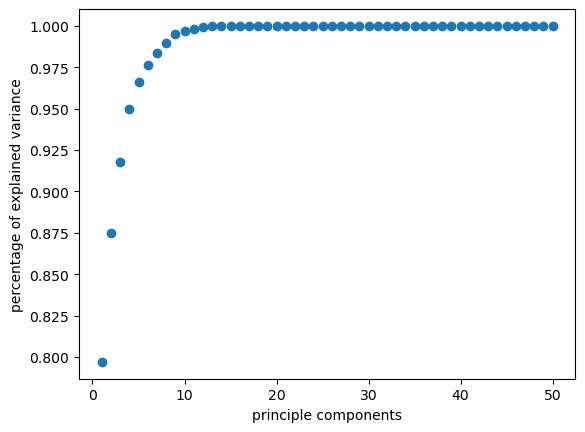

In [8]:
# Determine number of principle components based on percentage of information specified.
desired_percentage = 0.999
num_pc = pca_determine_num(df_post_alss, retain_percentage=desired_percentage)
print('Original: Number of PCs is: ', num_pc, f' which retains {desired_percentage} of variance')

show = True
if show:
    pca_show(df_post_alss, 50, 1, 1, False)

In [9]:
df_recomb = pd.concat([pnum, labels, df_post_alss],axis=1) 
df_avc, groups_avc, labels_avc = df_post_alss, pnum, pd.DataFrame(labels)

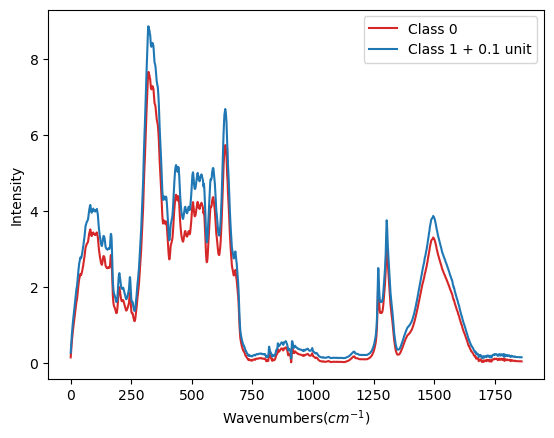

In [10]:
def plot_class_spectrum(samples_c1, samples_c2):
    spectra_c1 = samples_c1.iloc[:,:-1]
    spectra_c2 = samples_c2.iloc[:,:-1]

    # X = np.arange(750, 2612, 1)
    X = np.arange(samples_c1.shape[1]-1)
    y1 = spectra_c1.mean(axis=0)
    y2 = spectra_c2.mean(axis=0) + 0.1

    plt.plot(X, y1, color='tab:red', label='Class 0') 
    plt.plot(X, y2, color='tab:blue', label='Class 1 + 0.1 unit')

    plt.xlabel("Wavenumbers($cm^{-1}$)", fontsize=10) 
    plt.ylabel("Intensity", fontsize=10) 
    # plt.title("") 

    plt.legend() 
    plt.show() 

df_post_c0 = df_recomb[df_recomb['Label']==0].drop(columns=['Label', 'Patient'])
df_post_c1 = df_recomb[df_recomb['Label']==1].drop(columns=['Label', 'Patient'])
plot_class_spectrum(df_post_c0, df_post_c1)

## Separate PCAs

In [30]:
test = test_model(kfold = 10, model_name='svm', hp=[1,0.0001,'rbf'], df=df_avc, labels=labels_avc, _groups=groups_avc,verbose=1,zero_center=1,num_pc=num_pc, separate_pca = False, run_lda = True)
print('Acc:',test[0])
print('F1:',test[3])
print('Sen:',test[1])
print('Spec:',test[2])

Running Stratified Group K Fold Cross Validation
Running Cross Validation
Running test with hyperparameters C: 1 gamma: 0.0001 kernel: rbf
Completed split and shuffle
Input dimension is: 12
Input dimension is: 1
Isolated test set
Testing set ground truth labels:  0      1
13     0
21     1
32     0
40     1
52     0
60     0
71     1
80     1
90     0
101    1
112    0
120    0
130    1
141    0
151    1
160    0
170    1
183    0
197    1
Name: Label, dtype: int64
Finished dimensionality reduction, Number of principal components is: 12
Fold: 1   Accuracy: 0.95
Completed split and shuffle
Input dimension is: 12
Input dimension is: 1
Isolated test set
Testing set ground truth labels:  1      0
10     1
22     1
33     0
42     1
54     0
62     1
70     0
82     1
91     0
103    1
113    0
123    0
132    1
144    1
153    0
161    0
171    1
184    1
190    0
Name: Label, dtype: int64
Finished dimensionality reduction, Number of principal components is: 12
Fold: 2   Accuracy: 0.9
Comp

## K-Fold CV

In [12]:
save_figures = False
fig_path = './Figures/'

In [13]:
max_num_pcs = 50

In [14]:
# mean_accuracy_history = []
# mean_sen_history = []
# mean_spec_history = []
# mean_f1_history = []

# for i in range(1,max_num_pcs):
#     mean_acc, mean_sen, mean_spec, mean_f1 = test_model(kfold = 10, model_name='svm', hp=[1,0.0001,'linear'], df=df_avc, labels=labels_avc, _groups=groups_avc,verbose=1,zero_center=1,num_pc=i, separate_pca = True, run_lda = True)
#     mean_accuracy_history.append(mean_acc)
#     mean_sen_history.append(mean_sen)
#     mean_spec_history.append(mean_spec)
#     mean_f1_history.append(mean_f1)

In [15]:
# fig0 = plt.gcf()
# plt.plot(range(1,max_num_pcs), mean_accuracy_history,c='tab:red', linestyle='dashed', marker='o')
# plt.legend(['10-Fold Mean Accuracy'], loc='lower right')
# plt.ylabel('Mean Accuracy')
# plt.xlabel('Number of Principle Components')
# plt.show()

# # if save_figures:
# #     fig_name = dfpath +' kfold_mean_acc_to_num_of_PC.png'
# #     fig1.savefig(fig_path+fig_name)

In [16]:
# fig1 = plt.gcf()
# plt.plot(range(1,max_num_pcs), mean_f1_history,c='tab:orange', linestyle='dashed', marker='o')
# plt.legend(['10-Fold Mean F1 Score'], loc='lower left')
# plt.ylabel('Mean Accuracy')
# plt.xlabel('Number of Principle Components')
# plt.show()

# # if save_figures:
# #     fig_name = dfpath +' kfold_mean_acc_to_num_of_PC.png'
# #     fig1.savefig(fig_path+fig_name)

In [17]:
# fig2 = plt.figure(4)
# plt.plot(range(1,max_num_pcs), mean_sen_history,c='tab:green', linestyle='dashed', marker='o')
# plt.plot(range(1,max_num_pcs), mean_spec_history,c='tab:blue', linestyle='dashed', marker='o')
# plt.legend(['10-Fold Mean Sensitivity','10-Fold Mean Specificity'], loc='lower left')
# plt.ylabel('Score')
# plt.xlabel('Number of Principle Components')
# plt.show()

# # if save_figures:
# #     fig_name = dfpath +'kfold_senspec_to_num_of_PC.png'
# #     fig2.savefig(fig_path+fig_name)

## Testing with MNIST 

In [105]:
mnist_train = pd.read_csv('./MNIST/train.csv')
mnist_test = pd.read_csv('./MNIST/test.csv')

mnist_train_binary = mnist_train[(mnist_train['label']==5) | (mnist_train['label']==6)]

mnist_test_c0 = mnist_test[mnist_test['label']==5]
mnist_test_c1 = mnist_test[mnist_test['label']==6]
mnist_test_binary = mnist_test[(mnist_test['label']==5) | (mnist_test['label']==6)]

mnist_train_binary = mnist_train_binary.head(1000)
mnist_train_c0 = mnist_train_binary[mnist_train_binary['label']==5]
mnist_train_c1 = mnist_train_binary[mnist_train_binary['label']==6]

mnist_train_binary = mnist_train_binary.rename(columns={'label':'Label'})
mnist_train_binary = mnist_train_binary.reset_index(drop=True)
mnist_train_df = mnist_train_binary.drop(columns='Label')
mnist_trian_labels = pd.DataFrame(mnist_train_binary['Label'])
mnist_train_groups = pd.DataFrame(np.arange(len(mnist_train_binary)))

mnist_test_binary = mnist_test_binary.rename(columns={'label':'Label'})
mnist_test_binary = mnist_test_binary.reset_index(drop=True)
mnist_test_df = mnist_test_binary.drop(columns='Label')
mnist_test_labels = pd.DataFrame(mnist_test_binary['Label'])

mnist_trian_labels["Label"] = np.where(mnist_trian_labels["Label"] == 5, 0, 1)
mnist_test_labels["Label"] = np.where(mnist_test_labels["Label"] == 5, 0, 1)

In [106]:
X_train, X_test = pca(mnist_train_df, mnist_test_df, 200, 1)
X_train_2pca, X_test_2pca = pca_separated(mnist_train_df, mnist_test_df, mnist_trian_labels, 200, verbose=0, plot=0)

Percentage of variance explained:  0.9811019895346023
Performing PCA on each class separately


In [108]:
mnist_model = svm.SVC()
mnist_model.fit(X_train_2pca, mnist_trian_labels)
mnist_model.score(X_test_2pca, mnist_test_labels)

c:\Users\cjtan\AppData\Local\miniconda3\envs\BloodUrine\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9854054054054054

In [109]:
test = test_model(kfold = 10, model_name='svm', hp=[1,'scale','rbf'], df=mnist_train_df, labels=mnist_trian_labels, _groups=mnist_train_groups,verbose=1,zero_center=1,num_pc=200, separate_pca = False, run_lda = False)
print('Acc:',test[0])
print('F1:',test[3])
print('Sen:',test[1])
print('Spec:',test[2])

Running Stratified Group K Fold Cross Validation
Running Cross Validation
Running test with hyperparameters C: 1 gamma: scale kernel: rbf
Completed split and shuffle
Input dimension is: 200
Isolated test set
Testing set ground truth labels:  0      0
11     1
23     1
31     0
41     1
      ..
950    0
962    1
970    1
983    1
992    0
Name: Label, Length: 100, dtype: int32
Finished dimensionality reduction, Number of principal components is: 200
Fold: 1   Accuracy: 1.0
Completed split and shuffle
Input dimension is: 200
Isolated test set
Testing set ground truth labels:  1      0
12     1
24     1
33     1
40     0
      ..
951    0
965    1
971    1
984    0
990    1
Name: Label, Length: 100, dtype: int32
Finished dimensionality reduction, Number of principal components is: 200
Fold: 2   Accuracy: 0.96
Completed split and shuffle
Input dimension is: 200
Isolated test set
Testing set ground truth labels:  2      1
10     0
25     1
35     1
42     0
      ..
952    1
960    0
973  

In [110]:
test = test_model(kfold = 10, model_name='svm', hp=[1,'scale','rbf'], df=mnist_train_df, labels=mnist_trian_labels, _groups=mnist_train_groups,verbose=1,zero_center=1,num_pc=200, separate_pca = True, run_lda = False)
print('Acc:',test[0])
print('F1:',test[3])
print('Sen:',test[1])
print('Spec:',test[2])

Running Stratified Group K Fold Cross Validation
Running Cross Validation
Running test with hyperparameters C: 1 gamma: scale kernel: rbf
Completed split and shuffle
Performing PCA on each class separately
Percentage of class 0 variance explained:  0.9916399889090483
Percentage of class 1 variance explained:  0.9926427842758779
Input dimension is: 400
Isolated test set
Testing set ground truth labels:  0      0
11     1
23     1
31     0
41     1
      ..
950    0
962    1
970    1
983    1
992    0
Name: Label, Length: 100, dtype: int32
Finished dimensionality reduction, Number of principal components is: 200
Fold: 1   Accuracy: 1.0
Completed split and shuffle
Performing PCA on each class separately
Percentage of class 0 variance explained:  0.99147897876679
Percentage of class 1 variance explained:  0.9925124712433597
Input dimension is: 400
Isolated test set
Testing set ground truth labels:  1      0
12     1
24     1
33     1
40     0
      ..
951    0
965    1
971    1
984    0
99

### 1D - CNN

Shuffling
Device is  cuda
Training vs. Validation Loss {'Training': 0.7047940539736901, 'Validation': 0.7011562347412109} 154
[1] loss: 0.705
Training vs. Validation Loss {'Training': 0.586550304739015, 'Validation': 0.4760055333375931} 309
[2] loss: 0.587
Training vs. Validation Loss {'Training': 0.4301820605272247, 'Validation': 0.4963914766907692} 464
[3] loss: 0.430
Training vs. Validation Loss {'Training': 0.3858759406233026, 'Validation': 0.4223590835928917} 619
[4] loss: 0.386
Training vs. Validation Loss {'Training': 0.3461510475754978, 'Validation': 0.3712177760899067} 774
[5] loss: 0.346
Training vs. Validation Loss {'Training': 0.32170772226226907, 'Validation': 0.3328718490898609} 929
[6] loss: 0.322
Training vs. Validation Loss {'Training': 0.3077187504994893, 'Validation': 0.2764482002705336} 1084
[7] loss: 0.308
Training vs. Validation Loss {'Training': 0.26315537510710135, 'Validation': 0.17219908479601145} 1239
[8] loss: 0.263
Training vs. Validation Loss {'Training': 

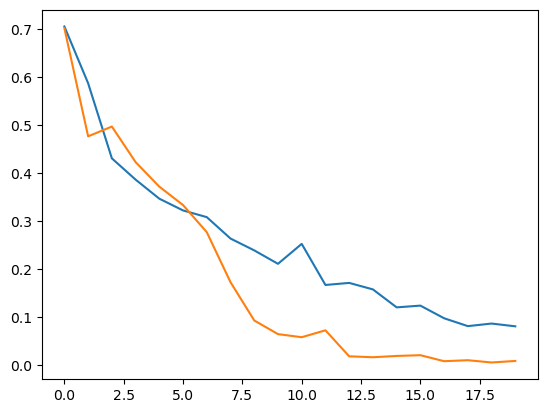

In [19]:
def get_train_test_split(df, scenario = 'avc', shuffle=True, num_test_patient=10, aug=False, synth = False):
    # Call function to adjust sample labels to fit binary scenario
    # spectra_avc, groups_avc, labels_avc = get_scenario_specs(scenario, df)
    # df_avc_full = pd.concat([groups_avc,labels_avc,spectra_avc],axis=1)
    df_avc_full = df

    if shuffle:
        print('Shuffling')
        # Shuffle whole data set by patient (group)
        groups = [df for _, df in df_avc_full.groupby('Patient')]
        random.Random().shuffle(groups)
        df_avc_full = pd.concat(groups).reset_index(drop=True)

    # Split data set into train/test sets
    num_test_patient = num_test_patient
    samp_per_patient = 12 if aug else 3 # each patient has 3/12 samples w/wo augmentation
    if synth:
        samp_per_patient = 1
    train_avc = df_avc_full.head(- (num_test_patient*samp_per_patient))
    test_avc = df_avc_full.tail(num_test_patient*samp_per_patient)

    # Split training set into training and validation sets
    num_val_patient = 5
    train_avc = train_avc.head(-(num_val_patient*samp_per_patient))
    val_avc = train_avc.tail(num_val_patient*samp_per_patient)

    # Take only original samples if no test time augmentation
    # test_time_aug = False
    # if not test_time_aug:
    #     result_df = pd.DataFrame()
    #     groups = [df for _, df in test_avc.groupby('Patient')]
    #     for group in groups:
    #         group = group[:3]
    #         result_df = pd.concat([result_df, group],axis=0).reset_index(drop=True)
    #     test_avc = result_df

    # Training groups, labels, and spectra
    groups_train_avc = train_avc['Patient'] # not sure if needed as of now
    labels_train_avc = pd.DataFrame(train_avc['Label'])
    spectra_train_avc = train_avc.drop(columns=['Patient','Label'])

    # Validation group, labels, and spectra
    groups_val_avc = val_avc['Patient']
    labels_val_avc = pd.DataFrame(val_avc['Label'])
    spectra_val_avc = val_avc.drop(columns=['Patient','Label'])

    # Testing groups, labels, and spectra
    groups_test_avc = test_avc['Patient'] # not sure if needed as of now
    labels_test_avc = test_avc['Label']
    spectra_test_avc = test_avc.drop(columns=['Patient','Label'])

    # print('Training set labels:', labels_train_avc)
    # print('Test set labels:', labels_test_avc)

    return df_avc_full, spectra_train_avc, labels_train_avc, spectra_val_avc, labels_val_avc, spectra_test_avc,labels_test_avc

df_full, X_train, y_train, X_val, y_val, X_test, y_test = get_train_test_split(df_recomb, num_test_patient=40, shuffle=True, synth=True)

do_zero_center = True
if do_zero_center:
    X_train, X_val, X_test = scale(X_train, X_test, X_val)

do_pca = False
if do_pca:
    num_pca = 9
    X_train, X_val, X_test = pca_cnn(X_train, X_val, X_test, num_components=num_pca, verbose=0, plot=0)

class TorchDataset(Dataset): # TODO: problem is here?
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples
    
train_dataset = TorchDataset(X_train, y_train)
val_dataset = TorchDataset(X_val, y_val)
test_dataset = TorchDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

class Conv1DNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1,kernel_size=3, stride=2,padding=1) 
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2,padding=1)

        self.conv2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)

        self.fc1 = nn.Linear(118*1*1, 32)
        self.fc2 = nn.Linear(32,1)

        # self.conv1 = nn.Conv1d(1, 16, 3, stride=1, padding=1)  # Convolutional layer
        # self.conv2 = nn.Conv1d(16, 32, 3, stride=1, padding=1)  # Convolutional layer
        # self.fc1 = nn.Linear(32 * (X_train.shape[1] // 2), 64)  # Fully connected layer
        # self.fc2 = nn.Linear(64, 2)  # Output layer
        # self.relu = nn.ReLU()
        # self.pool = nn.MaxPool1d(2, 2)
        # self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        # print("Original shape is", x.shape)
        x = F.leaky_relu(self.conv1(x))
        # print("Shape after Conv1 is", x.shape)
        x = self.pool(x)
        # print("Shape after maxpooling 1 is", x.shape)

        x = F.leaky_relu(self.conv2(x))
        # print("Shape after Conv2 is", x.shape)
        x = self.pool2(x)
        # print("Shape after maxpooling 2 is", x.shape)

        x = torch.flatten(x,1) # necessary?
        x = F.leaky_relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        # print("Shape after flatenning is", x.shape)
        return x        


# Manual Seed
torch.manual_seed(0)

aug = False

# Hyper-parameters
num_classes = 2 # only needed if 4-class
num_epochs = 50
batch_size = 1 # do more later
learning_rate = 0.01
total_samples = len(train_dataset)
n_iterations = math.ceil(total_samples/batch_size)

cnn_model = Conv1DNet().to(device)

print('Device is ', device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)


n_total_steps = len(train_loader)

train_loss_history = []
val_loss_history = []

for epoch in range(20):
    running_loss = 0.0

    for i, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # forward, get loss
        outputs = cnn_model(inputs)

        loss = criterion(outputs, labels)

        # backward, update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

            # running_loss = 0.0
        
        # if (i+1)%5==0:
        #     print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, inputs {inputs.shape}')

    running_vloss = 0.0
    cnn_model.train(False)
    for j, (vinputs, vlabels) in enumerate(val_loader):
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)
        voutputs = cnn_model(vinputs)
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss.item()
    cnn_model.train(True)

    
    # writer.add_scalars('Training vs. Validation Loss',
    #     { 'Training' : running_loss/n_total_steps, 'Validation' : running_vloss/len(val_loader_urine) },
    #     epoch * len(train_loader_urine) + i)

    print('Training vs. Validation Loss',
        { 'Training' : running_loss/n_total_steps, 'Validation' : running_vloss/len(val_loader) },
        epoch * len(train_loader) + i)
    
    train_loss_history.append(running_loss/n_total_steps)
    val_loss_history.append(running_vloss/len(val_loader))

    print(f'[{epoch + 1}] loss: {running_loss/n_total_steps:.3f}')

print('Finished Training')
# writer.flush()
# writer.close()
plt.plot(train_loss_history)
plt.plot(val_loss_history)
cnn_model.eval()
with torch.no_grad():
    num_correct = 0
    for samples, labels in test_loader:
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = cnn_model(samples)

        pred_label = int(outputs.cpu().numpy() > 0.5)
        print("pred: ", pred_label, "truth: ", labels)
        if pred_label == labels.item():
            num_correct+=1
    print('accuracy =', num_correct/len(test_dataset))